# Flight analysis visualization. 

The Europe visualizations notebook aims to describe and understand visually the data from all the data points of our study. The idea is to start having insights into what our data looks like. In this step, all the flights from all the countries selected are included.

NOTE: The analysis of this graphs are in the [Medium article](https://medium.com/@abreualberto91/flight-delays-in-europe-dad1af88711a).

NOTE 2: Spain and BCN visualization follow the same line of thought.

#### Hypothesis

- **Its is more likely to have delay time in Spain airports than in the rest of europe. (1)**


- **The Barcelona airport is the airport with less delays time in average of Spain. (2)**


- **Vueling is the air carrier with more delays on average (3)**


- **Daytime in terms of morning, afternoon and evening, night has an effect in classifiying the flight as a delayed flight.(4)**


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
import seaborn as sns
import datetime as dt
sns.set()

In [2]:
#Setting color, color palettes and the style of the visualizations. 

In [3]:
color_r='#C61437'
color_b='#005699'
color_p = '#5C0063'
redblue =['#C61437','#005699','#5C0063']

In [4]:
style.use('seaborn-notebook')

In [5]:
#Setting connection to the SQL PRO

In [6]:
driver = 'mysql+pymysql:'
user = 'root'
password = '19693903'
ip = '127.0.0.1'
database = 'project_4'

In [7]:
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [8]:
query = """
SELECT *
FROM flights
"""

In [9]:
data = pd.read_sql(query, engine)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85194 entries, 0 to 85193
Data columns (total 15 columns):
airln_name          85194 non-null object
airln_code          85194 non-null object
type                85194 non-null object
codeshared          56911 non-null object
status              85194 non-null object
icaonumb            84894 non-null object
flight              85194 non-null object
depart_terminal     61102 non-null object
depart_gate         66237 non-null object
depart_airpt        85194 non-null object
schd_depart_time    85179 non-null datetime64[ns]
depart_delay        85194 non-null int64
arri_airpt          85194 non-null object
schd_arri_time      85180 non-null datetime64[ns]
arri_delay          85194 non-null object
dtypes: datetime64[ns](2), int64(1), object(12)
memory usage: 9.7+ MB


### **Joining the flights data set with the airports data set to have, for each observation, the country of origin**

In [11]:
query = """
SELECT * FROM airports

"""

In [12]:
airports_info = pd.read_sql(query, engine)

In [13]:
airports_info.head()

,country_code,iata_code,name
0,ES,ABC,Los Llanos
1,ES,ACE,Lanzarote
2,ES,AEI,Algeciras
3,ES,AGP,Pablo Ruiz Picasso
4,ES,ALC,Alicante El Altet


In [14]:
data = data.merge(airports_info, left_on = 'depart_airpt', right_on='iata_code')

In [15]:
data = data.drop(columns = ('iata_code'), axis = 1).rename(columns = {'country_code':'depart_country'})

In [16]:
data = data.astype({'depart_delay': int,'arri_delay':int})

In [17]:
# Creating a new column called total delay 

data['Total_delay'] = data['depart_delay'] + data['arri_delay']

## Removing outliers

Since I have a lot of data, my sample won’t be hurt by dropping a questionable outlier. In this case, an outlier is a flight which total delay time is beyond 3.5 times the interquartile range plus the third quartile. I choose 3.5 since is the threshold that let me keep flights with total delay time is less than 6 hours. If a flight is delayed more than 6 hours, then the airline has to pay its passengers for the inconvenient. 


In [18]:
data.describe()

,depart_delay,arri_delay,Total_delay
count,85194.000000,85194.000000,85194.000000
mean,13.798366,12.306360,26.104726
std,20.234997,20.489029,39.373989
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,6.000000,4.000000,11.000000
75%,19.000000,16.000000,34.000000
max,280.000000,281.000000,560.000000


In [19]:
q1, q3= np.percentile(data['Total_delay'],[25,75])

In [20]:
iqr = q3 - q1

In [21]:
upper_bound = q3 +(3.5 * iqr)

In [22]:
upper_bound

149.5

In [23]:
data = data[data['Total_delay'] <= upper_bound]

In [24]:
data.describe()

,depart_delay,arri_delay,Total_delay
count,83464.000000,83464.000000,83464.000000
mean,11.987803,10.446420,22.434223
std,15.372360,15.467309,29.249133
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,6.000000,3.000000,11.000000
75%,18.000000,15.000000,32.000000
max,119.000000,148.000000,149.000000


## Descriptive statistics of the delays in minutes

In [25]:
df_delays = data[['depart_delay', 'arri_delay','Total_delay']]

In [26]:
df_delays =  df_delays[np.logical_and(df_delays['depart_delay']>0, df_delays['arri_delay']>0)]

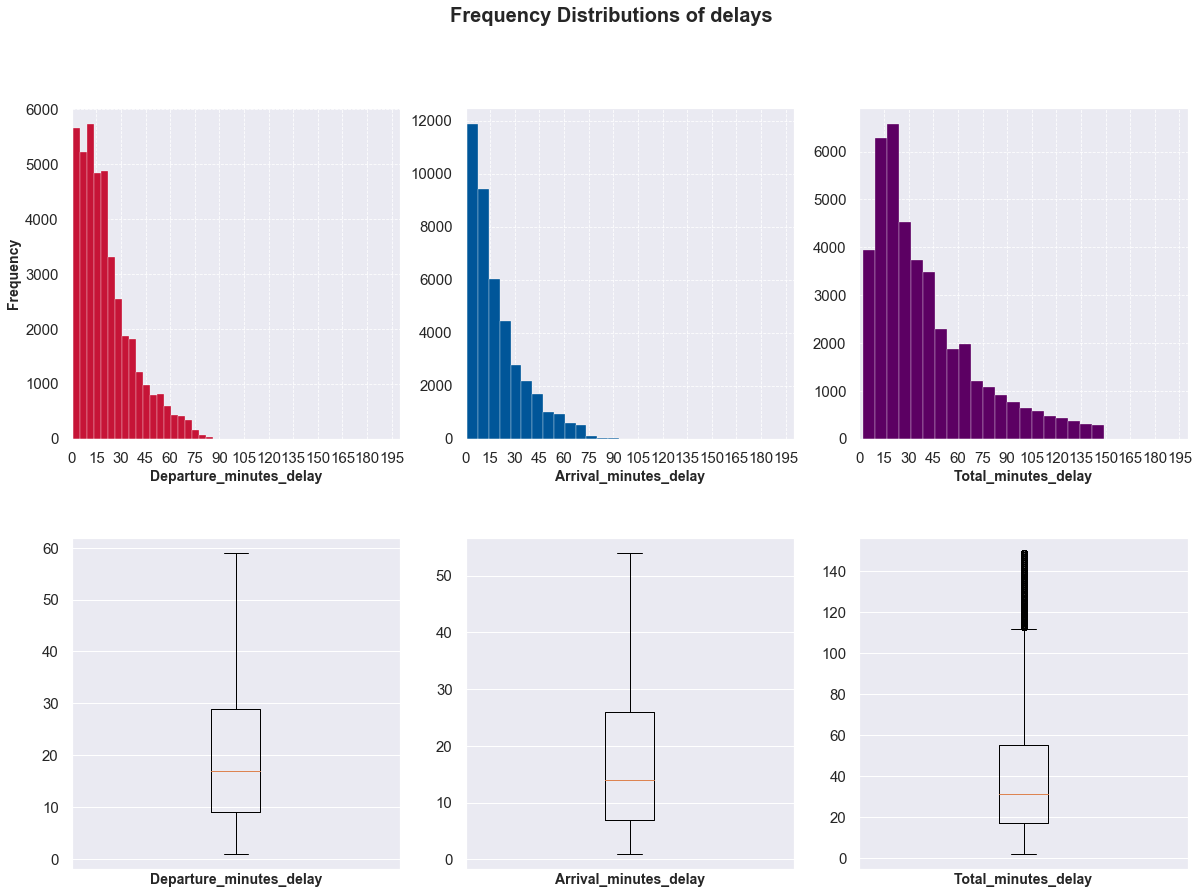

In [27]:
fig, [ax1, ax2] = plt.subplots(2,3, figsize=[20,14])
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Frequency Distributions of delays', fontweight = 900, fontsize = 20)

ax1[0].hist(df_delays.depart_delay,bins=20, color='#C61437')
ax1[0].set_xlabel('Departure_minutes_delay',fontweight = 900, fontsize = 14)
ax1[0].set_ylabel('Frequency',fontweight = 900, fontsize = 14)
ax1[0].grid(linestyle='--', linewidth=0.8)
ax1[0].set_xlim([0, 200])
ax1[0].tick_params(axis="x", labelsize=15)
ax1[0].tick_params(axis="y", labelsize=15)
ax1[0].set_xticks(np.arange(0, 200,15))

ax1[1].hist(df_delays.arri_delay, bins=20, color='#005699')
ax1[1].set_xlabel('Arrival_minutes_delay',fontweight = 900, fontsize = 14)
ax1[1].grid(linestyle='--', linewidth=0.8)
ax1[1].set_xlim([0, 200])
ax1[1].tick_params(axis="x", labelsize=15)
ax1[1].tick_params(axis="y", labelsize=15)
ax1[1].set_xticks(np.arange(0, 200,15))

ax1[2].hist(df_delays.Total_delay, bins=20, color=color_p)
ax1[2].set_xlabel('Total_minutes_delay',fontweight = 900, fontsize = 14)
ax1[2].grid(linestyle='--', linewidth=0.8)
ax1[2].set_xlim([0, 200])
ax1[2].tick_params(axis="x", labelsize=15)
ax1[2].tick_params(axis="y", labelsize=15)
ax1[2].set_xticks(np.arange(0, 200,15))

ax2[0].boxplot(df_delays.depart_delay, bootstrap=10000, meanline = True,showfliers=False)
ax2[0].set_xlabel('Departure_minutes_delay',fontweight = 900, fontsize = 14)
ax2[0].set_xticks([])
ax2[0].tick_params(axis="x", labelsize=15)
ax2[0].tick_params(axis="y", labelsize=15)

ax2[1].boxplot(df_delays.arri_delay, bootstrap=10000, meanline = True,showfliers=False)
ax2[1].set_xlabel('Arrival_minutes_delay',fontweight = 900, fontsize = 14)
ax2[1].set_xticks([])
ax2[1].tick_params(axis="x", labelsize=15)
ax2[1].tick_params(axis="y", labelsize=15)

ax2[2].boxplot(df_delays.Total_delay, bootstrap=10000, meanline = True,showfliers=True)
ax2[2].set_xlabel('Total_minutes_delay',fontweight = 900, fontsize = 14)
ax2[2].set_xticks([])
ax2[2].tick_params(axis="x", labelsize=15)
ax2[2].tick_params(axis="y", labelsize=15)

plt.savefig("delay_dist_eu.png")

plt.show()

In [28]:
df_delays.describe()

,depart_delay,arri_delay,Total_delay
count,41705.000000,41705.000000,41705.000000
mean,21.292339,18.988419,40.280758
std,16.298158,16.370961,31.411599
min,1.000000,1.000000,2.000000
25%,9.000000,7.000000,17.000000
50%,17.000000,14.000000,31.000000
75%,29.000000,26.000000,55.000000
max,86.000000,133.000000,149.000000


## Descriptive statistics of the time in hours of the day

In [29]:
depart_hours = data['schd_depart_time'].dt.hour
arri_hours = data['schd_arri_time'].dt.hour

In [30]:
df_hours_eu = pd.DataFrame([depart_hours, arri_hours])

In [31]:
df_hours_eu = df_hours_eu.transpose()

/Users/abreualberto91/anaconda3/envs/ironhack/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/abreualberto91/anaconda3/envs/ironhack/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


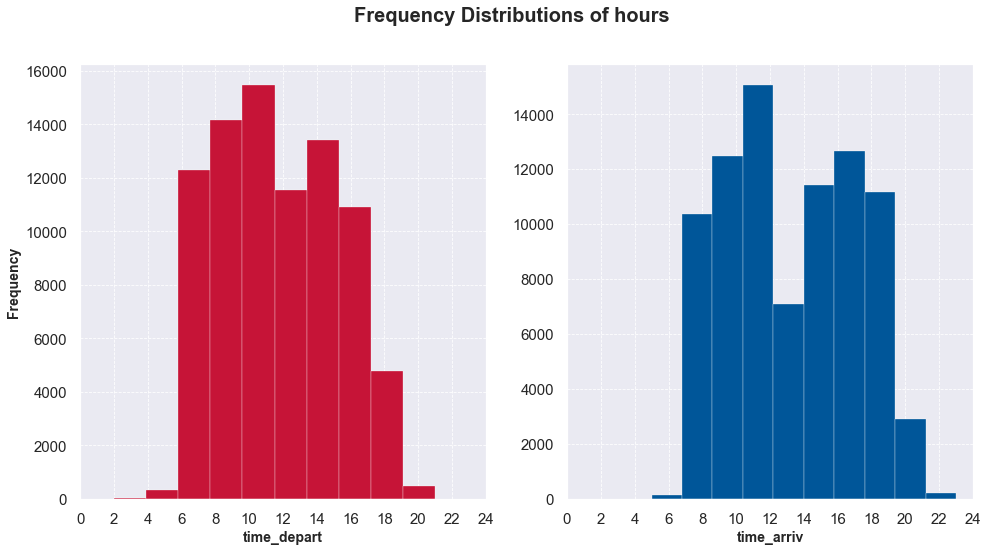

In [32]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=[16,8])
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Frequency Distributions of hours', fontweight = 900, fontsize = 20)

ax1.hist(depart_hours, color='#C61437')
ax1.set_xlabel('time_depart',fontweight = 900, fontsize = 14)
ax1.set_ylabel('Frequency',fontweight = 900, fontsize = 14)
ax1.grid(linestyle='--', linewidth=0.8)
ax1.set_xticks(np.arange(0, 26,2))
ax1.tick_params(axis="y", labelsize=15)
ax1.tick_params(axis="x", labelsize=15)

ax2.hist(arri_hours, color='#005699')
ax2.set_xlabel('time_arriv',fontweight = 900, fontsize = 14)
ax2.grid(linestyle='--', linewidth=0.8)
ax2.set_xticks(np.arange(0, 26,2))
ax2.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="x", labelsize=15)

plt.savefig("freq_dist_euflights.png")
plt.show()

In [33]:
df_hours_eu.describe()

,schd_depart_time,schd_arri_time
count,83449.000000,83450.000000
mean,11.743280,13.262253
std,3.705198,3.764429
min,2.000000,5.000000
25%,9.000000,10.000000
50%,11.000000,13.000000
75%,15.000000,16.000000
max,21.000000,23.000000


### Airlines distributions (main airlines of europe)

In [34]:
eu_airlines = data.groupby('airln_name').count()

In [35]:
eu_airlines = eu_airlines.sort_values(by=['airln_code'],ascending=False).drop(eu_airlines.iloc[:,1:], axis=1).\
rename(columns = {'airln_code':'total_count'}).reset_index(drop=False)


In [36]:
eu_airlines_top = eu_airlines[eu_airlines['total_count']>2000]

In [37]:
eu_airlines_top['per'] = eu_airlines_top['total_count'] / eu_airlines_top['total_count'].sum()

/Users/abreualberto91/anaconda3/envs/ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


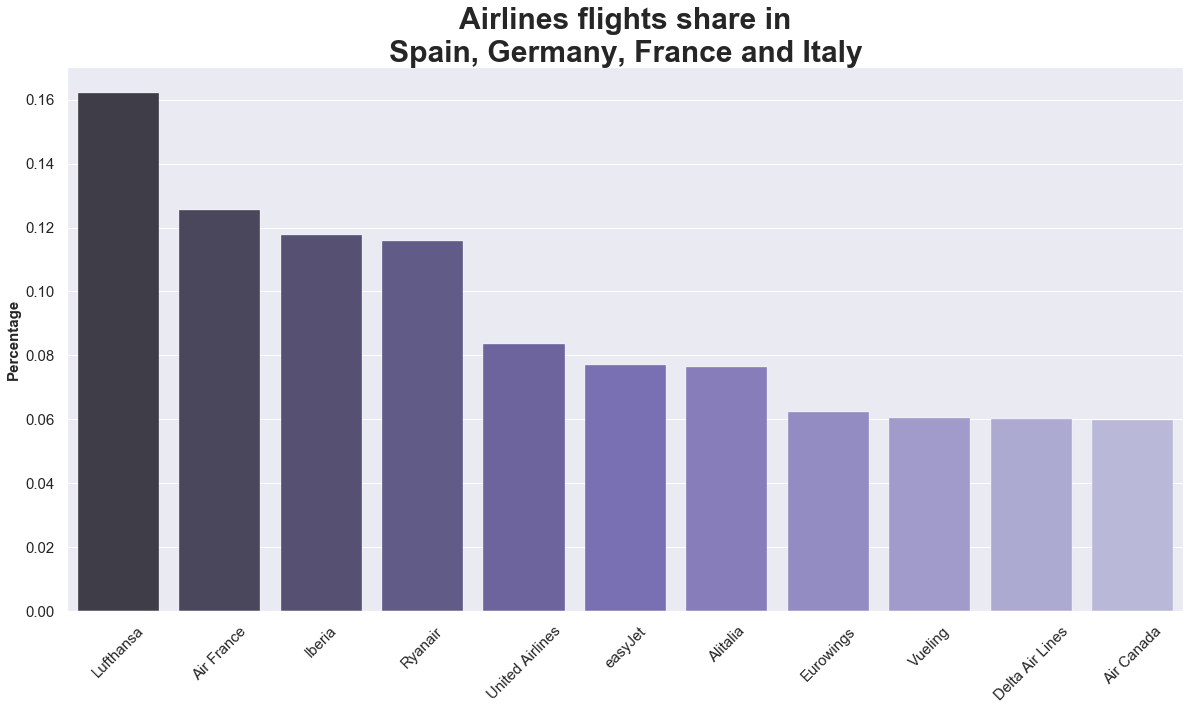

<Figure size 864x864 with 0 Axes>

In [38]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax = sns.barplot(eu_airlines_top.airln_name, eu_airlines_top.per, palette=('Purples_d'), saturation=1)

plt.title("Airlines flights share in\nSpain, Germany, France and Italy",  fontweight = 900, fontsize = 30)
plt.ylabel('Percentage',  fontweight = 900, fontsize = 15)
plt.xlabel(None)

plt.xticks(fontsize = 15, rotation=45)
plt.yticks(fontsize = 15)
plt.figure(figsize=(12,12))
sns.set_context("poster")
plt.savefig("market_share_eu.png")

In [39]:
eu_airlines.describe()

,total_count
count,203.000000
mean,411.152709
std,858.122629
min,1.000000
25%,6.000000
50%,64.000000
75%,374.500000
max,5995.000000


## Delay by weekday

In [40]:
import datetime as dt

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data ['weekday'] = data['schd_depart_time'].dt.dayofweek.map(dayOfWeek)


In [41]:
eu_delay_day = data.groupby('weekday').mean().reset_index(drop=False)
eu_delay_day = eu_delay_day.sort_values(by='weekday', ascending=True)
eu_delay_day.head()

,weekday,depart_delay,arri_delay,Total_delay
0,Friday,11.806245,9.801368,21.607613
1,Monday,9.916086,8.310107,18.226193
2,Saturday,14.436470,12.887865,27.324335
3,Sunday,13.803683,13.336577,27.140261
4,Thursday,11.973268,10.175728,22.148996


In [ ]:
index = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
eu_delay_day.index = eu.index.str.strip()

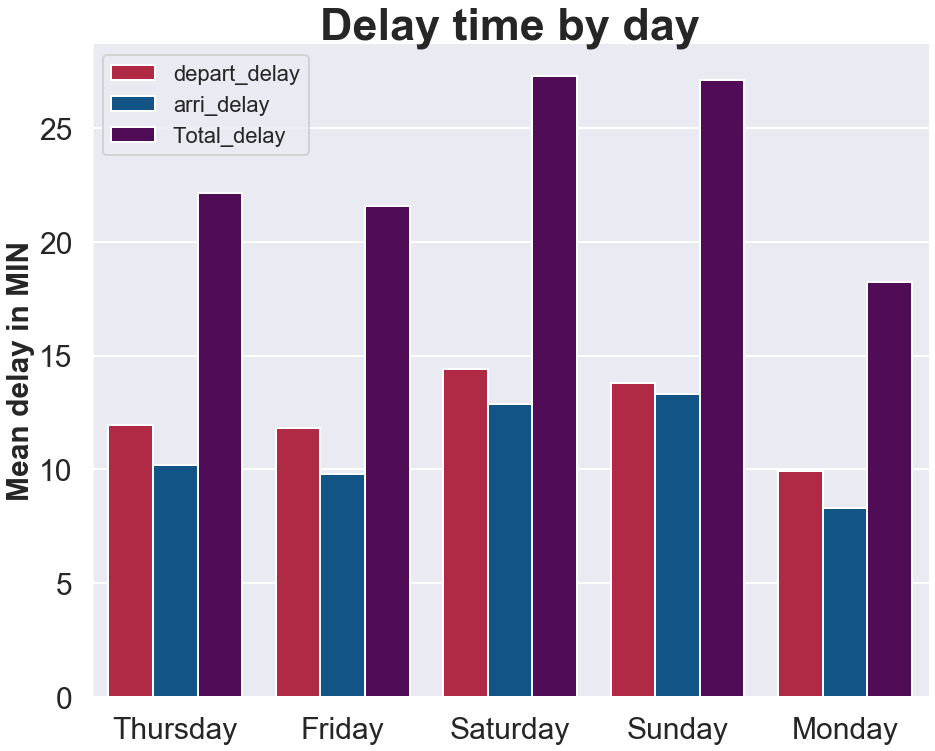

In [43]:

fig, ax1 = plt.subplots(figsize=(15,12))
tidy = eu_delay_day.melt(id_vars='weekday').rename(columns=str.title)
tidy.columns = ['Weekday', 'Type', 'Mean delay time']
sns.barplot(x='Weekday', y='Mean delay time', hue='Type', data=tidy, ax=ax1, palette=redblue, order=index)
plt.title('Delay time by day',fontweight = 900, fontsize = 45)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
ax1.set_ylabel('Mean delay in MIN',fontweight = 900, fontsize = 30)
ax1.set_xlabel('')
plt.legend()
sns.despine(fig)
plt.savefig("delay_eu_day.png")

In [44]:
weekday_delays = data[['weekday', 'depart_delay', 'arri_delay','Total_delay']]

In [45]:
weekday_delays = weekday_delays[np.logical_and(weekday_delays['depart_delay']>0, weekday_delays['arri_delay']>0)]

In [46]:
weekday_delays.head()

,weekday,depart_delay,arri_delay,Total_delay
18,Thursday,70,69,139
26,Thursday,16,2,18
36,Thursday,17,2,19
46,Thursday,7,15,22
47,Thursday,4,6,10


In [47]:
tidy_2 = weekday_delays.melt(id_vars='weekday').rename(columns=str.title)


In [48]:
tidy_2.columns = ['Weekday', 'Type', 'Delay in minutes']

In [49]:
tidy_2.head()

,Weekday,Type,Delay in minutes
0,Thursday,depart_delay,70
1,Thursday,depart_delay,16
2,Thursday,depart_delay,17
3,Thursday,depart_delay,7
4,Thursday,depart_delay,4


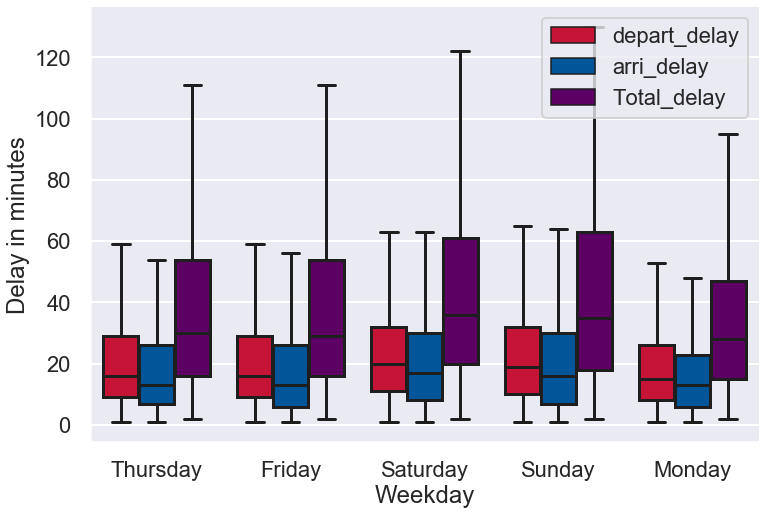

In [50]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax = sns.boxplot(x='Weekday', y='Delay in minutes', hue='Type',ax=ax1,
                 data=tidy_2, palette=redblue,showfliers=False, saturation = 1)

ax.legend()
sns.despine(fig)
plt.savefig("delay_eu_day_box.png")
plt.show()

## Relation between random variables

##### Relation between minutes of delay and day time

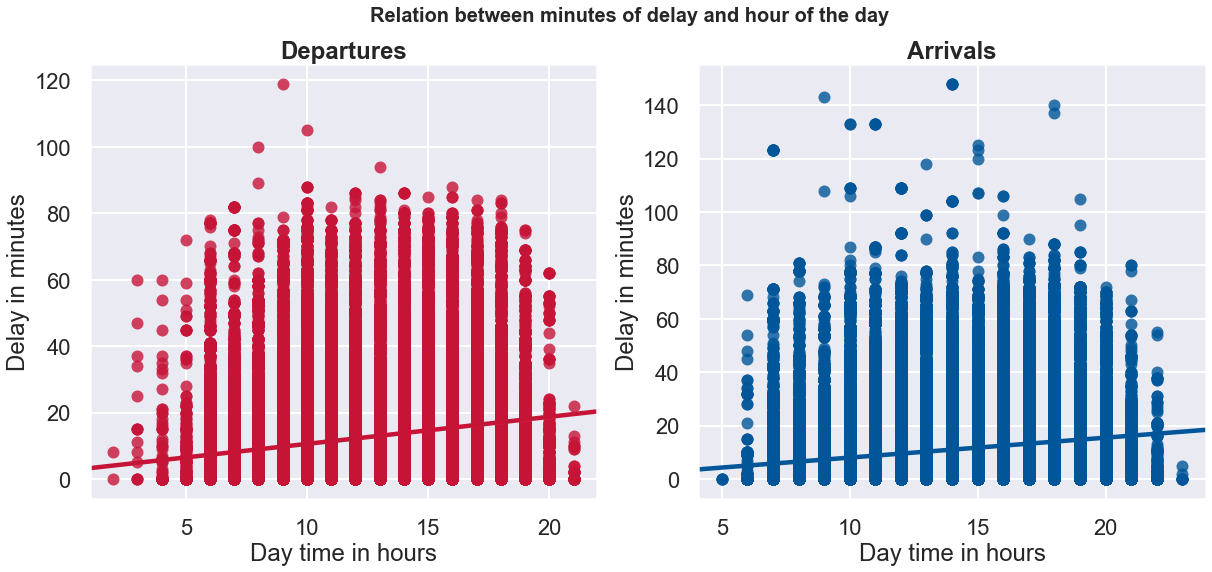

In [51]:
fig, ax1 = plt.subplots(1,2, figsize=[20,8])
fig.subplots_adjust(hspace=0.3)

sns.regplot(depart_hours, data.depart_delay, fit_reg=True, color=color_r,marker="o", label='departure', ax = ax1[0])
sns.regplot(arri_hours, data.arri_delay, fit_reg=True, color=color_b, marker="o", label='arrival', ax=ax1[1])

plt.suptitle('Relation between minutes of delay and hour of the day',fontweight = 900, fontsize = 20)
ax1[0].set_xlabel('Day time in hours')
ax1[0].set_ylabel('Delay in minutes')
ax1[0].set_title('Departures', fontweight = 900)

ax1[1].set_xlabel('Day time in hours')
ax1[1].set_ylabel('Delay in minutes')
ax1[1].set_title('Arrivals', fontweight = 900)
plt.savefig("relation_daytime_eu.png")
plt.show()



##### Relation between delay in departures and total delay

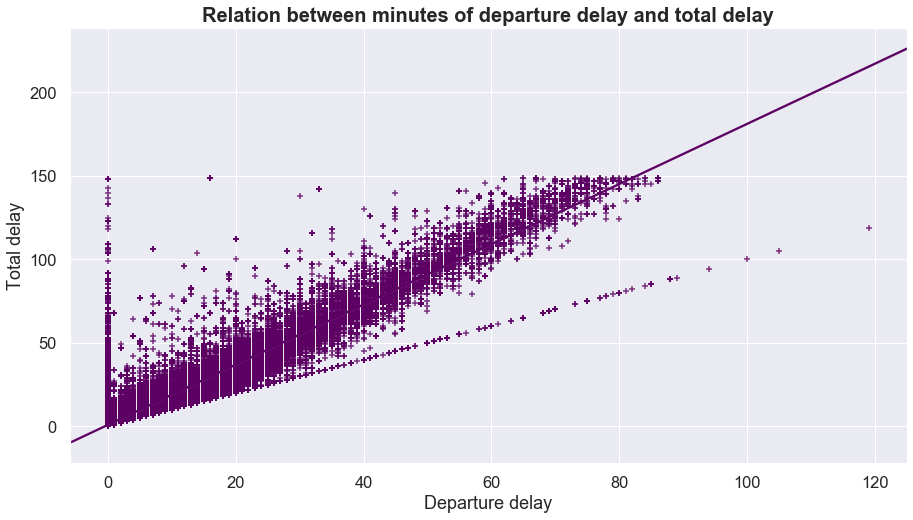

In [52]:
sns.set(font_scale=1.5)

fig,ax = plt.subplots(figsize=(15,8))

ax1 =sns.regplot(data.depart_delay, data.Total_delay, fit_reg=True, color=color_p, marker="+")

ax1.set(ylabel='Total delay', xlabel='Departure delay')
plt.title('Relation between minutes of departure delay and total delay',fontweight = 900, fontsize = 20)
plt.savefig("dept_total_rel_eu.png")

plt.show()

### Delay time for the airlines with more flights

In [53]:
top_airlines = ['lufthansa', 'Iberia', 'Air France', 'Ryanair', 'United Airlines', 'easy_jet', 'Alitalia', 'Vueling']


In [54]:
eu_airlns_dels_top = data[data['airln_name'].isin(top_airlines)]

In [55]:
eu_airlns_dels_top = eu_airlns_dels_top[np.logical_and(eu_airlns_dels_top['depart_delay']>0,\
                                                         eu_airlns_dels_top['arri_delay']>0)]

In [56]:
eu_airlns_dels_top = eu_airlns_dels_top[['airln_name','depart_delay', 'arri_delay','Total_delay' ]]

In [57]:
tidy_4 = eu_airlns_dels_top.melt(id_vars='airln_name').rename(columns=str.title)

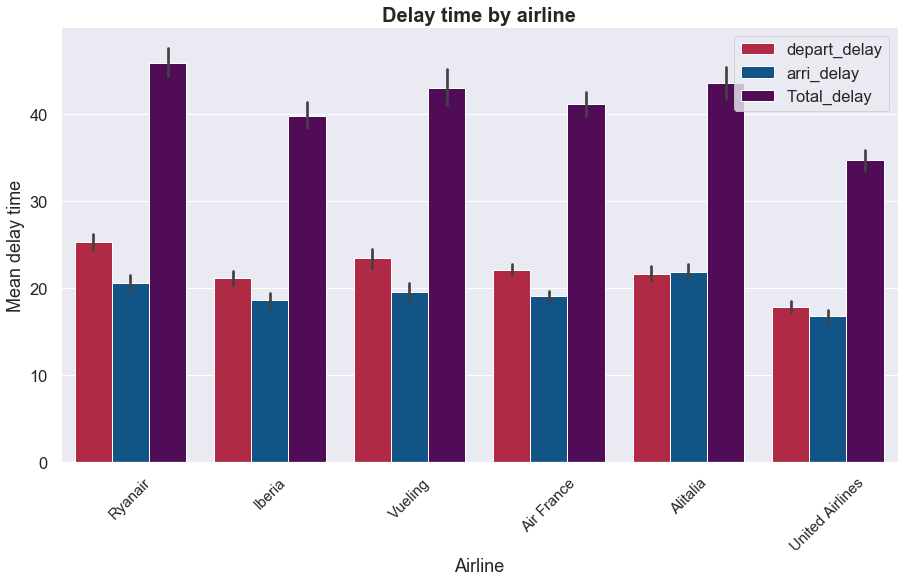

In [58]:

fig, ax1 = plt.subplots(figsize=(15,8))
tidy_4.columns = ['Airline', 'Type', 'Mean delay time']
sns.barplot(x='Airline', y='Mean delay time', hue='Type', data=tidy_4, ax=ax1, palette=redblue)
plt.title('Delay time by airline',fontweight = 900, fontsize = 20)
plt.legend()
plt.xticks(fontsize = 15, rotation=45)
sns.despine(fig)
plt.savefig("delay_weekday_eu.png")


### Delay times mean for the worst airlines

In [65]:
eu_airlines_delays = data.groupby('airln_name').mean().reset_index(drop=False)

In [66]:
eu_airlines_delays_worst = eu_airlines_delays[eu_airlines_delays['Total_delay']>60]
                                                    
eu_airlines_delays_worst = eu_airlines_delays_worst.sort_values(by = 'Total_delay', ascending=False)

In [67]:
tidy_3 = eu_airlines_delays_worst.melt(id_vars='airln_name').rename(columns=str.title)


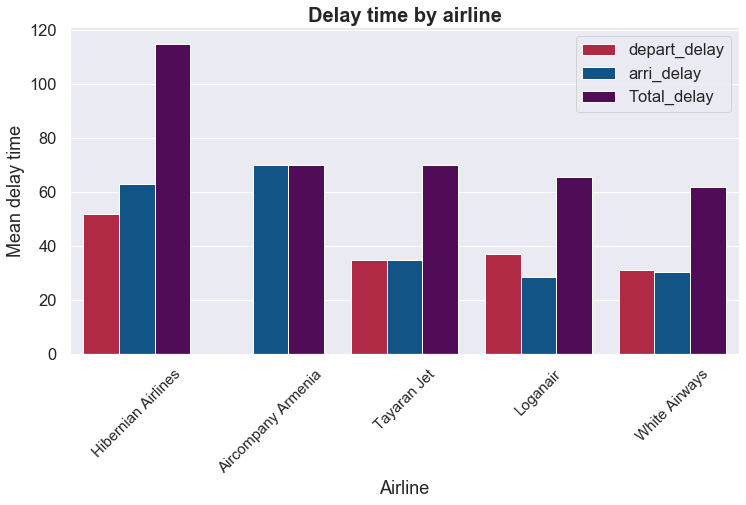

In [68]:
fig, ax1 = plt.subplots(figsize=(12,6))
tidy_3.columns = ['Airline', 'Type', 'Mean delay time']
sns.barplot(x='Airline', y='Mean delay time', hue='Type', data=tidy_3, ax=ax1, palette=redblue)
plt.title('Delay time by airline',fontweight = 900, fontsize = 20)
plt.legend()
plt.xticks(fontsize = 15, rotation=45)
plt.savefig("delay_airline_worst_eu.png")
sns.despine(fig)